In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os

import cmasher as cmr
import gc
import scipy.cluster.hierarchy as hcluster

from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, roc_curve
PATH = Path('../..').resolve()

seed = 256

# Results from Section 4.1 in nb 01

In [3]:
res = pd.read_csv(f'{PATH}/results/desi-sv/results_4_1.csv')
res.sample(10)

,OBJID,RA,DEC,r_mag,HOSTID,SPEC_Z,SATS,lower_z,low_z,SPEC_FLAG,kfold_split,pred_low_z
87352,902988630000002975,35.990729,-5.590450,18.754927,b'nsa155005',0.171180,0,False,False,1,True,0.001062
13152,903485240000000048,219.000897,2.896540,18.774178,b'nsa145372',0.179980,0,False,False,1,True,0.001789
78025,903456480000001227,220.056405,2.523927,18.654673,b'nsa145372',0.190160,0,False,False,1,True,0.003843
52452,903002970000000660,35.872972,-5.321373,18.786743,b'nsa155005',0.210600,0,False,False,1,True,0.000971
53935,916107910000000257,193.550707,57.814315,16.108822,b'nsa52773',0.055512,0,False,False,1,True,0.058265
541,900977410000006597,321.147777,-45.068152,16.734432,b'pgc66669',0.115353,0,False,False,1,True,0.010418
92811,903123960000004458,186.966043,-3.326814,18.439978,b'nsa3469',0.080953,0,False,False,1,True,0.548561
93816,903470700000004539,215.703483,2.711224,19.314974,b'nsa164865',0.388640,0,False,False,1,True,0.001783
108940,903528690000004831,226.795917,3.697513,20.411999,b'nsa165956',0.695311,0,False,False,1,True,0.002469
31317,904456920000002383,247.928662,20.369083,17.477823,b'nsa147100',0.058837,0,False,False,1,True,0.224147


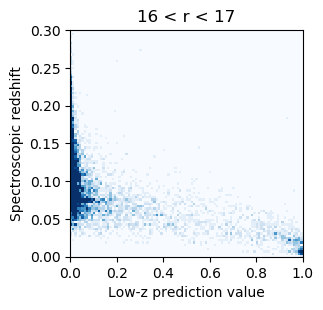

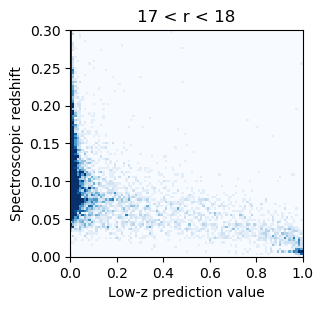

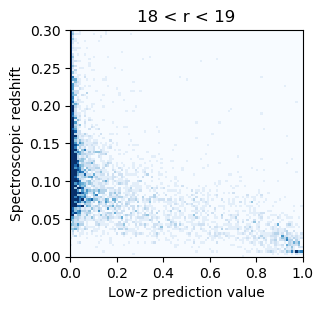

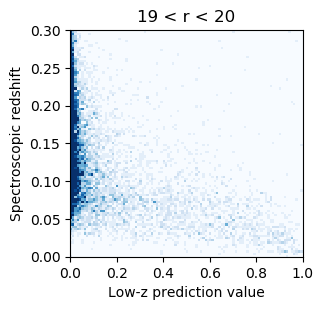

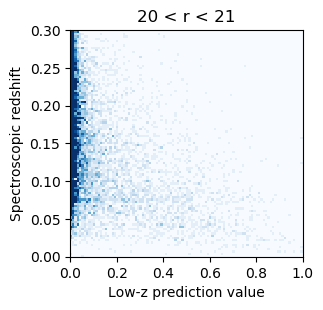

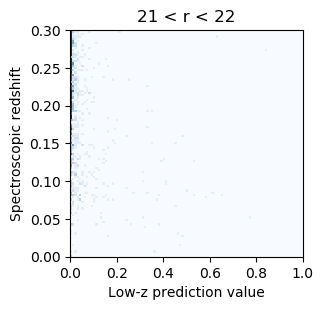

In [7]:
for r2 in range(17, 23):
    r1 = r2-1
    mag_range = (res.r_mag >= r1) & (res.r_mag < r2)
    
    plt.figure(figsize=(3, 3), dpi=100)
    plt.hist2d(res[mag_range].pred_low_z, res[mag_range].SPEC_Z, bins=(100, 100), range=([0., 1], [0., 0.3]), vmax=10, cmap='Blues');
    plt.xlabel('Low-z prediction value')
    plt.ylabel('Spectroscopic redshift');
    plt.title(f'{r1} < r < {r2}')
    plt.show()

# Results from Section 4.2 in nb 01

In [14]:
res = pd.read_csv(f'{PATH}/results/desi-sv/results_4_2.csv')
res.sample(10)

,OBJID,RA,DEC,r_mag,HOSTID,SPEC_Z,SATS,lower_z,low_z,SPEC_FLAG,kfold_split,pred_low_z
56147,902974260000006044,35.304147,-5.769065,19.859453,b'nsa155005',0.440830,0,False,False,1,True,0.000096
101667,915825640000002916,210.624906,49.588272,20.043026,b'nsa69028',0.509953,0,False,False,1,True,0.001229
46374,902548900000007503,54.025685,-13.236976,17.209558,b'pgc13166',0.067040,0,False,False,1,True,0.292137
96484,915698570000001663,169.019054,46.370844,20.581615,b'nsa159593',0.598369,0,False,False,1,True,0.476290
71252,900321900000002459,333.374805,-64.826239,19.721169,b'pgc68312',0.078801,0,False,False,1,True,0.222214
49110,902395350000003917,49.760879,-15.879684,15.934816,b'nsa133355',0.071791,0,False,False,1,True,0.030218
31466,901215310000002282,39.041788,-39.156450,18.542507,b'pgc9747',0.183906,0,False,False,1,True,0.030537
54943,904440900000004105,182.345709,20.041894,20.418467,b'nsa161174',0.075363,0,False,False,1,True,0.002034
30784,915729670000001666,217.375525,46.885318,17.560059,b'nsa51348',0.108235,0,False,False,1,True,0.003857
3130,903312520000002609,221.109974,0.122729,20.538992,b'nsa165536',0.260298,0,False,False,1,True,0.024179


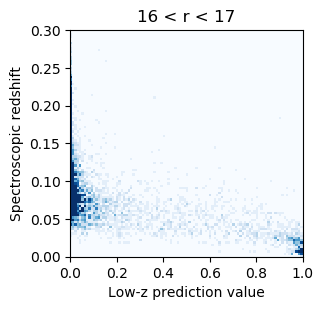

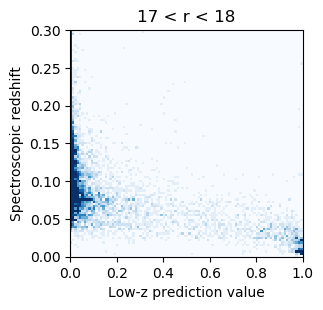

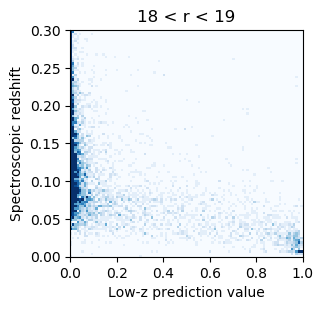

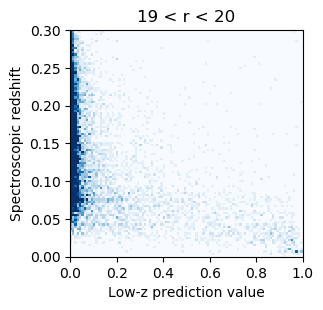

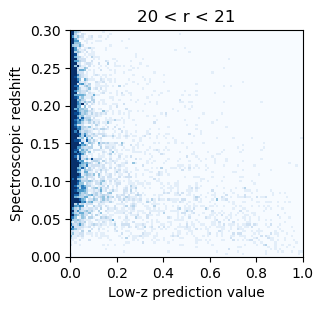

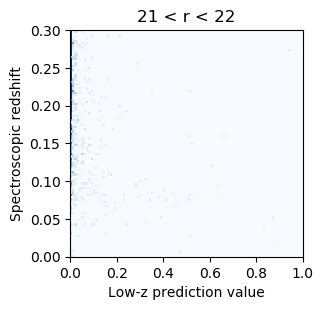

In [15]:
for r2 in range(17, 23):
    r1 = r2-1
    mag_range = (res.r_mag >= r1) & (res.r_mag < r2)
    
    plt.figure(figsize=(3, 3), dpi=100)
    plt.hist2d(res[mag_range].pred_low_z, res[mag_range].SPEC_Z, bins=(100, 100), range=([0, 1], [0., 0.3]), vmax=10, cmap='Blues');
    plt.xlabel('Low-z prediction value')
    plt.ylabel('Spectroscopic redshift');
    plt.title(f'{r1} < r < {r2}')
    plt.show()

# Results from Section 4.3 in nb 01

In [12]:
res = pd.read_csv(f'{PATH}/results/desi-sv/results_4_3.csv')
res.sample(10)

,OBJID,RA,DEC,r_mag,HOSTID,SPEC_Z,SATS,lower_z,low_z,SPEC_FLAG,kfold_split,pred_low_z
84125,903442020000003728,218.651120,2.216076,18.793005,b'nsa145372',0.314450,0,False,False,1,True,0.287137
32612,903441050000004826,194.423001,2.187307,20.106405,b'nsa14409',0.559518,0,False,False,1,True,0.287735
58868,901729310000007623,41.449258,-28.464625,20.039225,b'pgc10330',0.540590,0,False,False,1,True,0.289232
59523,903115530000005613,335.937727,-3.588445,19.941298,b'nsa149781',0.319657,0,False,False,1,True,0.288803
26961,903147260000001295,49.554829,-2.739569,17.537107,b'pgc12342',0.026783,0,False,True,1,True,0.292155
42070,916099310000000240,154.119180,57.443204,17.266602,b'nsa16559',0.180491,0,False,False,1,True,0.292725
11648,915959210000002809,139.584651,53.217494,19.567038,b'nsa16235',0.040629,0,False,False,1,True,0.356233
8751,903591030000005597,348.444295,4.732432,19.628841,b'nsa150887',0.308664,0,False,False,1,True,0.288312
45250,916060240000001122,175.647170,56.134847,20.460316,b'nsa160302',0.549663,0,False,False,1,True,0.289352
75330,916107100000002004,156.026662,57.661611,20.513124,b'nsa16559',0.544683,0,False,False,1,True,0.290104


In [46]:
# res.sort_values('pred_low_z', ascending=False)

In [47]:
# plt.hist2d(res.pred_low_z, res.SPEC_Z, bins=(100, 100), range=([0.25, 0.75], [0., 0.3]), vmax=50, cmap='Blues');
# plt.xlabel('Low-z prediction value')
# plt.ylabel('Spectroscopic redshift');

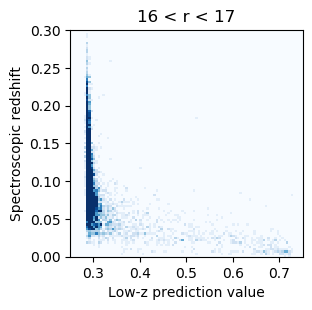

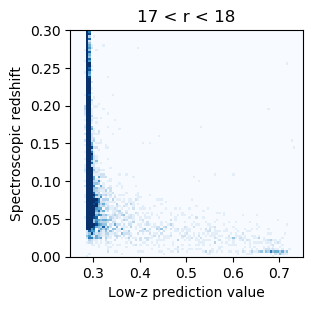

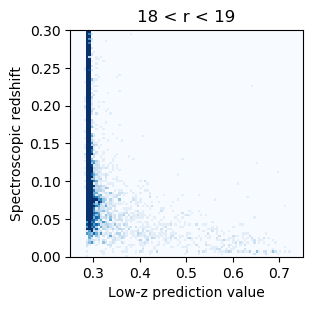

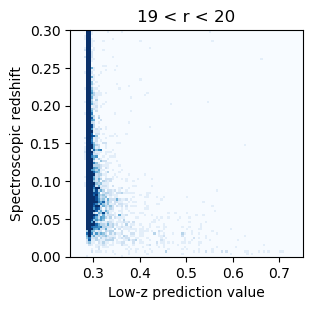

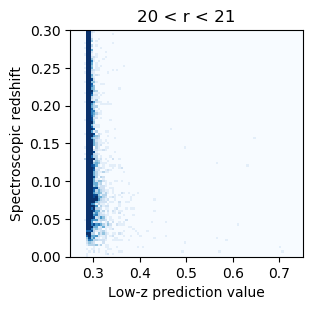

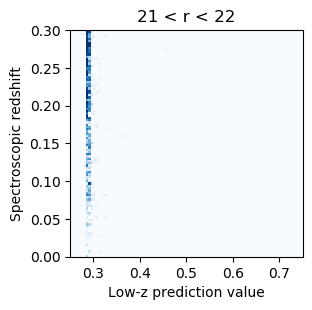

In [39]:
for r2 in range(17, 23):
    r1 = r2-1
    mag_range = (res.r_mag >= r1) & (res.r_mag < r2)
    
    plt.figure(figsize=(3, 3), dpi=100)
    plt.hist2d(res[mag_range].pred_low_z, res[mag_range].SPEC_Z, bins=(100, 100), range=([0.25, 0.75], [0., 0.3]), vmax=10, cmap='Blues');
    plt.xlabel('Low-z prediction value')
    plt.ylabel('Spectroscopic redshift');
    plt.title(f'{r1} < r < {r2}')
    plt.show()

Is there a way to make it learn more of the fainter examples? Like perhaps we need to resample fainter things more often?

In [42]:
print('Number of low-z galaxies')
for r2 in range(17, 23):
    r1 = r2-1
    mag_range = (res.r_mag >= r1) & (res.r_mag < r2)
    
    print(f'    {r1} < r < {r2}: {(res[mag_range].SPEC_Z < 0.03).sum()}')

Number of low-z galaxies
    16 < r < 17: 387
    17 < r < 18: 443
    18 < r < 19: 394
    19 < r < 20: 289
    20 < r < 21: 185
    21 < r < 22: 11


In [48]:
# faint = res[(res.r_mag > 19) & (res.r_mag < 20)]
# faint[faint.SPEC_Z < 0.03][['RA', 'DEC']].sample(20)

In [49]:
# faint = res[(res.r_mag > 20) & (res.r_mag < 21)]
# faint[faint.SPEC_Z < 0.03][['RA', 'DEC']].sample(20)

# Results from section 4.4 in nb 01 

In [50]:
res = pd.read_csv(f'{PATH}/results/desi-sv/results_4_4.csv')
res.sample(10)

,OBJID,RA,DEC,r_mag,HOSTID,SPEC_Z,SATS,lower_z,low_z,SPEC_FLAG,kfold_split,pred_low_z
27334,903426080000002346,180.098847,2.074603,20.430973,b'nsa13927',0.569955,0,False,False,1,True,0.290414
51181,903398860000004300,219.657862,1.474068,17.577112,b'nsa145372',0.177920,0,False,False,1,True,0.289175
8115,916175900000002895,228.079358,60.066615,21.101248,b'nsa165980',0.284900,0,False,False,1,True,0.289011
98175,903298270000005331,224.968179,-0.180212,16.879220,b'nsa145729',0.099228,0,False,False,1,True,0.287477
92976,915587060000003053,207.753234,43.598637,17.431484,b'nsa143856',0.137033,0,False,False,1,True,0.289854
76827,903129880000002773,335.072950,-3.267450,20.238523,b'nsa149781',0.586942,0,False,False,1,True,0.289064
73266,916028670000001713,219.055672,55.286678,16.864273,b'nsa145297',0.137064,0,False,False,1,True,0.289618
64650,903442060000003057,219.636701,2.141876,19.379930,b'nsa145372',0.353980,0,False,False,1,True,0.287321
59334,904443380000001601,248.048992,19.902589,17.145424,b'nsa147100',0.090800,0,False,False,1,True,0.288952
15607,900589100000005260,326.826147,-55.450002,17.156504,b'pgc67532',0.038729,0,False,False,1,True,0.438620


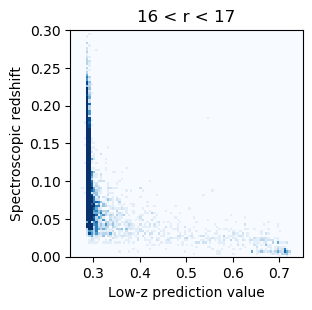

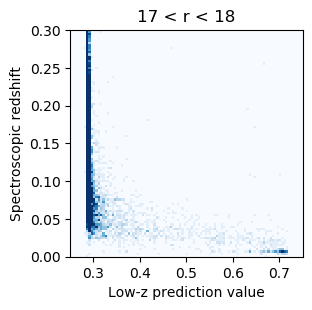

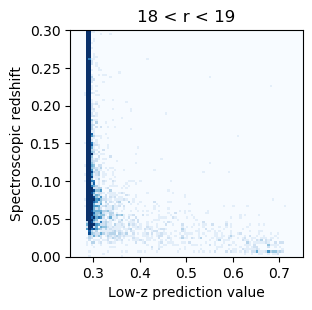

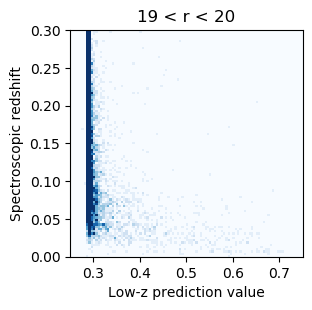

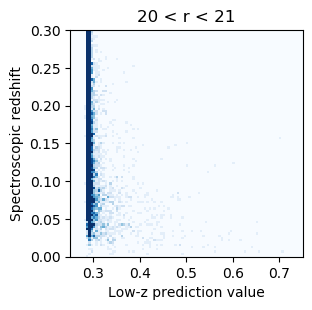

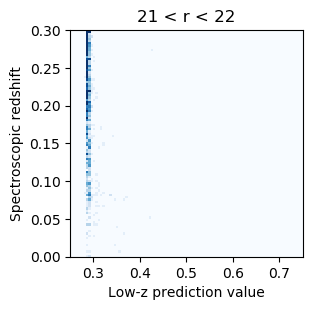

In [51]:
for r2 in range(17, 23):
    r1 = r2-1
    mag_range = (res.r_mag >= r1) & (res.r_mag < r2)
    
    plt.figure(figsize=(3, 3), dpi=100)
    plt.hist2d(res[mag_range].pred_low_z, res[mag_range].SPEC_Z, bins=(100, 100), range=([0.25, 0.75], [0., 0.3]), vmax=10, cmap='Blues');
    plt.xlabel('Low-z prediction value')
    plt.ylabel('Spectroscopic redshift');
    plt.title(f'{r1} < r < {r2}')
    plt.show()

# Purity as a function of magnitude

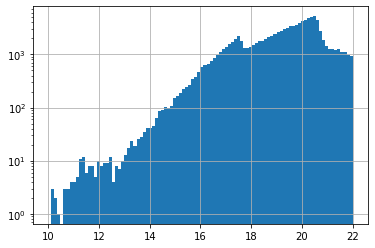

In [82]:
res.r_mag.hist(bins=100, range=[10, 22], log=True)


In [81]:
mags = np.arange(17, 24, 0.5)
for r in mags:
    mag_range = (res.r_mag >= r-0.5) & (res.r_mag < r)
    
    n_in_range = sum(res[mag_range].SPEC_Z < 0.03)
    cdf = sum(res[res.r_mag < r].SPEC_Z < 0.03)
    frac = n_in_range / len(res[mag_range])
    print(f'{r-0.5:.1f}-{r:.1f}: {n_in_range}\t (cdf:{cdf}, frac={frac:.4f})')

16.5-17.0: 216	 (cdf:1226, frac=0.0484)
17.0-17.5: 242	 (cdf:1468, frac=0.0332)
17.5-18.0: 201	 (cdf:1669, frac=0.0311)
18.0-18.5: 198	 (cdf:1867, frac=0.0286)
18.5-19.0: 196	 (cdf:2063, frac=0.0218)
19.0-19.5: 164	 (cdf:2227, frac=0.0135)
19.5-20.0: 125	 (cdf:2352, frac=0.0083)
20.0-20.5: 124	 (cdf:2476, frac=0.0062)
20.5-21.0: 61	 (cdf:2537, frac=0.0048)
21.0-21.5: 10	 (cdf:2547, frac=0.0019)
21.5-22.0: 1	 (cdf:2548, frac=0.0002)
22.0-22.5: 2	 (cdf:2550, frac=0.0010)
22.5-23.0: 0	 (cdf:2550, frac=0.0000)
23.0-23.5: 0	 (cdf:2550, frac=0.0000)


Note that faintest low-z galaxies in sample are only around $r \sim 22$.

In [25]:
(res[res.SPEC_Z < 0.03]).sort_values('r_mag').tail()

,OBJID,RA,DEC,r_mag,HOSTID,SPEC_Z,SATS,lower_z,low_z,SPEC_FLAG,kfold_split,pred_low_z
80662,903269440000002366,224.100026,-0.788616,21.353190,b'nsa145729',0.017135,2,True,True,1,True,0.287446
15951,902945610000004400,35.574376,-6.316225,21.416103,b'nsa155005',0.008250,4,True,True,1,True,0.289150
80618,903224770000002956,187.422273,-1.563847,21.778908,b'nsa141465',0.024097,0,False,True,1,True,0.289703
73759,903341330000004832,221.479031,0.577172,22.086490,b'nsa165536',0.004988,4,True,True,1,True,0.288651
34385,902931280000000428,35.204597,-6.452448,22.203800,b'nsa155005',0.014270,2,True,True,1,True,0.290066


In [83]:
colors = ['#4e79a7', '#59a14f', '#edc948', '#e15759']
labels = ['pCNN (W)', 'hdCNN (W)',  'pCNN (LS)', 'hdCNN (LS)']

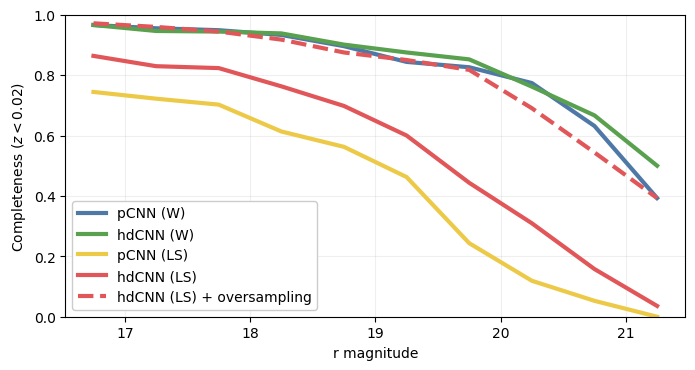

In [97]:
plt.figure(figsize=(8,4), dpi=100)
p_thresh = 0.5
low_z_thresh = 0.02

for j, color, label in zip(range(1, 5), colors, labels):
    
    for i, ls, addendum in zip([4, 5], ['-', '--'], ['', ' + oversampling']):
    
        if os.path.exists(f'{PATH}/results/desi-sv/results_{i}_{j}.csv'):
            res = pd.read_csv(f'{PATH}/results/desi-sv/results_{i}_{j}.csv')
        else:
            continue
        
        mags = np.arange(17, 22, 0.5)

        purity = []
        completeness= []
        for r2 in mags:
            r1 = r2-1
            mag_range = (res.r_mag >= r1) & (res.r_mag < r2)
            subset = res[mag_range]

            TP = ((subset.pred_low_z > p_thresh) & (subset.SPEC_Z < low_z_thresh)).sum()
            TN = ((subset.pred_low_z < p_thresh) & (subset.SPEC_Z > low_z_thresh)).sum()
            FP = ((subset.pred_low_z > p_thresh) & (subset.SPEC_Z > low_z_thresh)).sum()
            FN = ((subset.pred_low_z < p_thresh) & (subset.SPEC_Z < low_z_thresh)).sum()

            purity.append(TP / (TP + FP))
            completeness.append(TP / (TP + FN))

        plt.plot(mags-0.25, completeness, color=color, lw=3, ls=ls, label=label+addendum)
plt.ylim(0, 1)
plt.xlabel('r magnitude')
plt.ylabel('Completeness ($z < 0.02$)')
plt.grid(alpha=0.2)
plt.legend(framealpha=1)

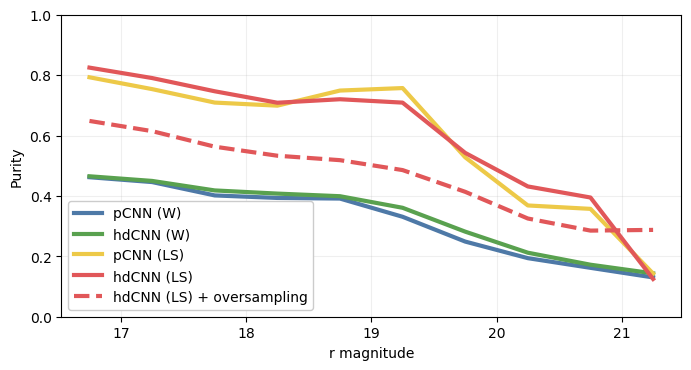

In [117]:
plt.figure(figsize=(8,4), dpi=100)
p_thresh = 0.5
low_z_thresh = 0.03

for j, color, label in zip(range(1, 5), colors, labels):
    
    for i, ls, addendum in zip([4, 5], ['-', '--'], ['', ' + oversampling']):
    
        if os.path.exists(f'{PATH}/results/desi-sv/results_{i}_{j}.csv'):
            res = pd.read_csv(f'{PATH}/results/desi-sv/results_{i}_{j}.csv')
        else:
            continue
        
        mags = np.arange(17, 22, 0.5)

        purity = []
        completeness= []
        for r2 in mags:
            r1 = r2-1
            mag_range = (res.r_mag >= r1) & (res.r_mag < r2)
            subset = res[mag_range]

            TP = ((subset.pred_low_z > p_thresh) & (subset.SPEC_Z < low_z_thresh)).sum()
            TN = ((subset.pred_low_z < p_thresh) & (subset.SPEC_Z > low_z_thresh)).sum()
            FP = ((subset.pred_low_z > p_thresh) & (subset.SPEC_Z > low_z_thresh)).sum()
            FN = ((subset.pred_low_z < p_thresh) & (subset.SPEC_Z < low_z_thresh)).sum()

            purity.append(TP / (TP + FP))
            completeness.append(TP / (TP + FN))

        plt.plot(mags-0.25, purity, color=color, lw=3, ls=ls, label=label+addendum)
plt.ylim(0, 1)
plt.xlabel('r magnitude')
plt.ylabel('Purity')
plt.grid(alpha=0.2)
plt.legend(framealpha=1)

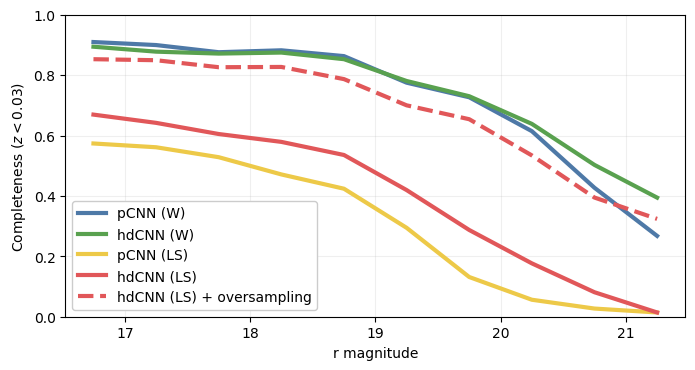

In [115]:
plt.figure(figsize=(8,4), dpi=100)
p_thresh = 0.5
low_z_thresh = 0.03

for j, color, label in zip(range(1, 5), colors, labels):
    
    for i, ls, addendum in zip([4, 5], ['-', '--'], ['', ' + oversampling']):
    
        if os.path.exists(f'{PATH}/results/desi-sv/results_{i}_{j}.csv'):
            res = pd.read_csv(f'{PATH}/results/desi-sv/results_{i}_{j}.csv')
        else:
            continue
        
        mags = np.arange(17, 22, 0.5)

        purity = []
        completeness= []
        for r2 in mags:
            r1 = r2-1
            mag_range = (res.r_mag >= r1) & (res.r_mag < r2)
            subset = res[mag_range]

            TP = ((subset.pred_low_z > p_thresh) & (subset.SPEC_Z < low_z_thresh)).sum()
            TN = ((subset.pred_low_z < p_thresh) & (subset.SPEC_Z > low_z_thresh)).sum()
            FP = ((subset.pred_low_z > p_thresh) & (subset.SPEC_Z > low_z_thresh)).sum()
            FN = ((subset.pred_low_z < p_thresh) & (subset.SPEC_Z < low_z_thresh)).sum()

            purity.append(TP / (TP + FP))
            completeness.append(TP / (TP + FN))

        plt.plot(mags-0.25, completeness, color=color, lw=3, ls=ls, label=label+addendum)
plt.ylim(0, 1)
plt.xlabel('r magnitude')
plt.ylabel('Completeness ($z < 0.03$)')
plt.grid(alpha=0.2)
plt.legend(framealpha=1)

# More model comparisons with magnitude-based oversampling

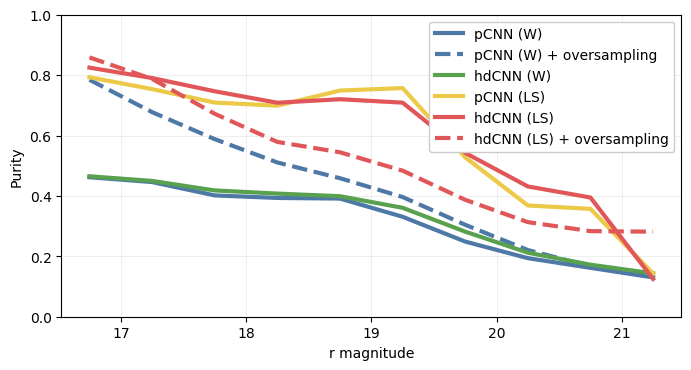

In [124]:
plt.figure(figsize=(8,4), dpi=100)
p_thresh = 0.5
low_z_thresh = 0.03

for j, color, label in zip(range(1, 5), colors, labels):
    
    for i, ls, addendum in zip([4, 7], ['-', '--'], ['', ' + oversampling']):
    
        if os.path.exists(f'{PATH}/results/desi-sv/results_{i}_{j}.csv'):
            res = pd.read_csv(f'{PATH}/results/desi-sv/results_{i}_{j}.csv')
        else:
            continue
        
        mags = np.arange(17, 22, 0.5)

        purity = []
        completeness= []
        for r2 in mags:
            r1 = r2-1
            mag_range = (res.r_mag >= r1) & (res.r_mag < r2)
            subset = res[mag_range]

            TP = ((subset.pred_low_z > p_thresh) & (subset.SPEC_Z < low_z_thresh)).sum()
            TN = ((subset.pred_low_z < p_thresh) & (subset.SPEC_Z > low_z_thresh)).sum()
            FP = ((subset.pred_low_z > p_thresh) & (subset.SPEC_Z > low_z_thresh)).sum()
            FN = ((subset.pred_low_z < p_thresh) & (subset.SPEC_Z < low_z_thresh)).sum()

            purity.append(TP / (TP + FP))
            completeness.append(TP / (TP + FN))

        plt.plot(mags-0.25, purity, color=color, lw=3, ls=ls, label=label+addendum)
plt.ylim(0, 1)
plt.xlabel('r magnitude')
plt.ylabel('Purity')
plt.grid(alpha=0.2)
plt.legend(framealpha=1)

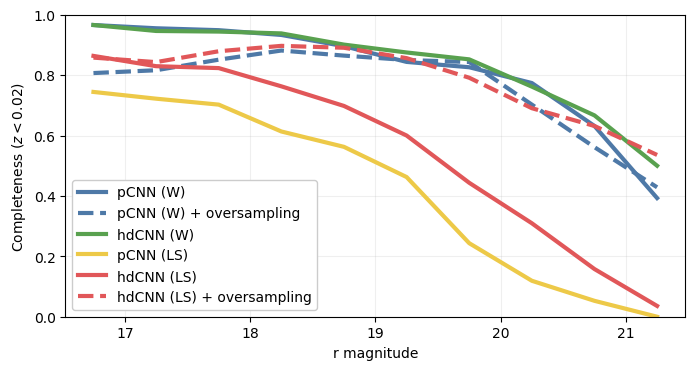

In [125]:
plt.figure(figsize=(8,4), dpi=100)
p_thresh = 0.5
low_z_thresh = 0.02

for j, color, label in zip(range(1, 5), colors, labels):
    
    for i, ls, addendum in zip([4, 7], ['-', '--'], ['', ' + oversampling']):
    
        if os.path.exists(f'{PATH}/results/desi-sv/results_{i}_{j}.csv'):
            res = pd.read_csv(f'{PATH}/results/desi-sv/results_{i}_{j}.csv')
        else:
            continue
        
        mags = np.arange(17, 22, 0.5)

        purity = []
        completeness= []
        for r2 in mags:
            r1 = r2-1
            mag_range = (res.r_mag >= r1) & (res.r_mag < r2)
            subset = res[mag_range]

            TP = ((subset.pred_low_z > p_thresh) & (subset.SPEC_Z < low_z_thresh)).sum()
            TN = ((subset.pred_low_z < p_thresh) & (subset.SPEC_Z > low_z_thresh)).sum()
            FP = ((subset.pred_low_z > p_thresh) & (subset.SPEC_Z > low_z_thresh)).sum()
            FN = ((subset.pred_low_z < p_thresh) & (subset.SPEC_Z < low_z_thresh)).sum()

            purity.append(TP / (TP + FP))
            completeness.append(TP / (TP + FN))

        plt.plot(mags-0.25, completeness, color=color, lw=3, ls=ls, label=label+addendum)
plt.ylim(0, 1)
plt.xlabel('r magnitude')
plt.ylabel('Completeness ($z < 0.02$)')
plt.grid(alpha=0.2)
plt.legend(framealpha=1)

# Faint candidates that the `4_4` model got wrong

## Predicted to be at low-z

In [45]:
res = pd.read_csv(f'{PATH}/results/desi-sv/results_4_4.csv')
faint = res[(res.r_mag > 20) & (res.pred_low_z > 0.5)]

In [62]:
(faint[['RA', 'DEC', 'SPEC_Z']].reset_index(drop=True)
    .style.apply(
        lambda x: ['background-color: #ff6361' if x.SPEC_Z < 0.03 else '' for i in x],
        axis=1
    )
)

,RA,DEC,SPEC_Z
0,25.100906,-7.909552,0.375382
1,0.690528,20.755808,0.078280
2,9.248439,-63.668883,0.014615
3,180.882151,1.779433,0.033864
4,353.243724,0.722448,0.121564
5,342.310198,-11.310854,0.025183
6,218.666867,51.693477,0.084967
7,233.945404,16.596223,0.029232
8,221.355953,0.048858,0.034231
9,207.581893,41.377351,0.008409


## Missed low-z

In [64]:
missed = res[(res.SPEC_Z < 0.03) & (res.pred_low_z < 0.5) & (res.r_mag > 19)]
missed.shape

(389, 12)

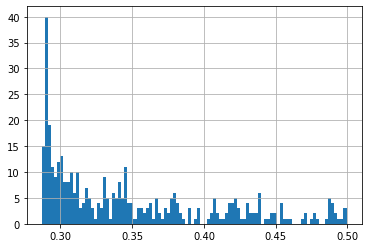

In [66]:
missed.pred_low_z.hist(bins=100)

In [67]:
missed[['RA', 'DEC']].sample(20, random_state=42)

,RA,DEC
77955,49.635599,-1.923571
12386,46.609495,-16.260535
45254,145.748895,0.749145
11437,242.163190,0.444654
99795,215.184181,50.920873
49366,222.035761,-0.466825
39996,320.798375,-45.950107
10354,33.105956,-32.153509
30805,25.716604,-7.692907
38826,222.006031,-0.314418


# Evaluating metrics on faint (r>19.5) galaxies

In [37]:
def get_metrics(results, mag_cut=19.5, p_thresh=0.5):
    
    subset = results[results.r_mag > mag_cut]
    metrics = {}
    
    # z<0.02
    low_z_thresh = 0.02
    TP = ((subset.pred_low_z > p_thresh) & (subset.SPEC_Z < low_z_thresh)).sum()
    TN = ((subset.pred_low_z < p_thresh) & (subset.SPEC_Z > low_z_thresh)).sum()
    FP = ((subset.pred_low_z > p_thresh) & (subset.SPEC_Z > low_z_thresh)).sum()
    FN = ((subset.pred_low_z < p_thresh) & (subset.SPEC_Z < low_z_thresh)).sum()
    
    metrics['completeness_02'] = TP / (TP + FN)

    # z<0.03
    low_z_thresh = 0.03
    TP = ((subset.pred_low_z > p_thresh) & (subset.SPEC_Z < low_z_thresh)).sum()
    TN = ((subset.pred_low_z < p_thresh) & (subset.SPEC_Z > low_z_thresh)).sum()
    FP = ((subset.pred_low_z > p_thresh) & (subset.SPEC_Z > low_z_thresh)).sum()
    FN = ((subset.pred_low_z < p_thresh) & (subset.SPEC_Z < low_z_thresh)).sum()
    metrics['completeness_03'] = TP / (TP + FN)
    metrics['purity_03'] = TP / (TP + FP)
    
    metrics['harmonic_mean'] = np.sqrt(metrics['completeness_02'] * metrics['purity_03'])
    
    return metrics

## No constraint on magnitude

In [38]:
labels = ['pCNN (W)', 'hdCNN (W)',  'pCNN (LS)', 'hdCNN (LS)']
metrics_dict = {}

for j, label in zip(range(1, 5), labels):
    
    for i, addendum in zip([4,5,6,7], ['', ' +oversample (10k)', ' +zoom', ' +zoom +oversample (mag)']):
    
        if os.path.exists(f'{PATH}/results/desi-sv/results_{i}_{j}.csv'):
            res = pd.read_csv(f'{PATH}/results/desi-sv/results_{i}_{j}.csv')
        else:
            continue
        
        metrics_dict[label+addendum] = get_metrics(res, mag_cut=-99)
        
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index')
metrics_df.sort_values('harmonic_mean', ascending=False)

,completeness_02,completeness_03,purity_03,harmonic_mean
hdCNN (LS) +zoom,0.786463,0.574118,0.805724,0.796035
hdCNN (LS),0.778405,0.579216,0.768470,0.773421
hdCNN (LS) +zoom +oversample (mag),0.879130,0.692549,0.620520,0.738592
hdCNN (LS) +oversample (10k),0.914585,0.801961,0.565229,0.718993
pCNN (LS),0.665592,0.475686,0.776072,0.718712
pCNN (W) +zoom +oversample (mag),0.852538,0.679608,0.515007,0.662619
hdCNN (W),0.929089,0.854902,0.413819,0.620061
pCNN (W),0.925060,0.847843,0.390676,0.601164


## r > 19.0

In [39]:
metrics_dict = {}

for j, label in zip(range(1, 5), labels):
    
    for i, addendum in zip([4,5,6,7], ['', ' +oversample (10k)', ' +zoom', ' +zoom +oversample (mag)']):
    
        if os.path.exists(f'{PATH}/results/desi-sv/results_{i}_{j}.csv'):
            res = pd.read_csv(f'{PATH}/results/desi-sv/results_{i}_{j}.csv')
        else:
            continue
        
        metrics_dict[label+addendum] = get_metrics(res, mag_cut=19.0)
        
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index')
metrics_df.sort_values('harmonic_mean', ascending=False)

,completeness_02,completeness_03,purity_03,harmonic_mean
hdCNN (LS) +oversample (10k),0.697802,0.542094,0.362140,0.502695
hdCNN (LS) +zoom +oversample (mag),0.708791,0.554415,0.343075,0.493121
hdCNN (LS) +zoom,0.351648,0.197125,0.623377,0.468198
hdCNN (W),0.752747,0.628337,0.233588,0.419324
pCNN (W) +zoom +oversample (mag),0.714286,0.556468,0.237095,0.411526
hdCNN (LS),0.329670,0.201232,0.513089,0.411279
pCNN (W),0.719780,0.593429,0.213916,0.392393
pCNN (LS),0.170330,0.088296,0.483146,0.286870


## r > 19.5

In [146]:
metrics_dict = {}

for j, label in zip(range(1, 5), labels):
    
    for i, addendum in zip([4,5,6,7], ['', ' +oversample (10k)', ' +zoom', ' +zoom +oversample (mag)']):
    
        if os.path.exists(f'{PATH}/results/desi-sv/results_{i}_{j}.csv'):
            res = pd.read_csv(f'{PATH}/results/desi-sv/results_{i}_{j}.csv')
        else:
            continue
        
        metrics_dict[label+addendum] = get_metrics(res, mag_cut=19.5)
        
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index')
metrics_df.sort_values('harmonic_mean', ascending=False)

,completeness_02,purity_03,harmonic_mean
hdCNN (LS)+zoom +oversample (mag),0.640351,0.306159,0.442775
hdCNN (LS) +oversample (10k),0.605263,0.315789,0.437191
hdCNN (W),0.684211,0.197050,0.367183
pCNN (W)+zoom +oversample (mag),0.622807,0.197368,0.350603
pCNN (W),0.666667,0.183174,0.349451
hdCNN (LS) +zoom,0.228070,0.530120,0.347713
hdCNN (LS),0.236842,0.409091,0.311272
pCNN (LS),0.087719,0.333333,0.170996


## r > 20

In [145]:
metrics_dict = {}

for j, label in zip(range(1, 5), labels):
    
    for i, addendum in zip([4,5,6,7], ['', ' +oversample (10k)', ' +zoom', '+zoom +oversample (mag)']):
    
        if os.path.exists(f'{PATH}/results/desi-sv/results_{i}_{j}.csv'):
            res = pd.read_csv(f'{PATH}/results/desi-sv/results_{i}_{j}.csv')
        else:
            continue
        
        metrics_dict[label+addendum] = get_metrics(res, mag_cut=20)
        
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index')
metrics_df.sort_values('harmonic_mean', ascending=False)

,completeness_02,purity_03,harmonic_mean
hdCNN (LS)+zoom +oversample (mag),0.567164,0.279503,0.398151
hdCNN (LS) +oversample (10k),0.492537,0.275735,0.368524
hdCNN (W),0.582090,0.169643,0.314241
pCNN (W),0.537313,0.155819,0.289350
hdCNN (LS) +zoom,0.149254,0.551724,0.286961
pCNN (W)+zoom +oversample (mag),0.492537,0.160075,0.280790
hdCNN (LS),0.134328,0.394737,0.230270
pCNN (LS),0.044776,0.294118,0.114758


## What if we combined model predictions?

For example: `hdCNN (LS) +zoom` (`6_4`) model with the `hdCNN (LS)+zoom +oversample (mag)` (`7_4`) model?
or `6_4` with `5_4`?

In [14]:
res_6_4x7_4 = pd.read_csv(f'{PATH}/results/desi-sv/results_6_4.csv').join(
    pd.read_csv(f'{PATH}/results/desi-sv/results_7_4.csv', index_col='OBJID'),
    on='OBJID', rsuffix='_7_4'
)

# take harmonic mean of predictions (works better than average, max, min, ...)
res_6_4x7_4['pred_low_z'] = np.sqrt(res_6_4x7_4['pred_low_z'] * res_6_4x7_4['pred_low_z_7_4'])

metrics_dict = {}
for mag_cut in [-99, 19, 19.5, 20]:
    metrics_dict[mag_cut] = get_metrics(res_6_4x7_4, mag_cut=mag_cut)
        
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index')
metrics_df.sort_values('harmonic_mean', ascending=False)

,completeness_02,purity_03,harmonic_mean
-99.0,0.841257,0.753555,0.796199
19.0,0.560440,0.527273,0.543603
19.5,0.482456,0.497608,0.489973
20.0,0.328358,0.484848,0.399004


5_4 x 6_4

In [20]:
res_6_4x5_4 = pd.read_csv(f'{PATH}/results/desi-sv/results_6_4.csv').join(
    pd.read_csv(f'{PATH}/results/desi-sv/results_5_4.csv', index_col='OBJID'),
    on='OBJID', rsuffix='_5_4'
)

# take harmonic mean of predictions (works better than average, max, min, ...)
res_6_4x5_4['pred_low_z'] = np.sqrt(res_6_4x5_4['pred_low_z'] * res_6_4x5_4['pred_low_z_5_4'])

metrics_dict = {}
for mag_cut in [-99, 19, 19.5, 20]:
    metrics_dict[mag_cut] = get_metrics(res_6_4x5_4, mag_cut=mag_cut)
        
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index')
metrics_df.sort_values('harmonic_mean', ascending=False)

,completeness_02,purity_03,harmonic_mean
-99.0,0.863014,0.724948,0.790974
19.0,0.543956,0.570447,0.557044
19.5,0.464912,0.530726,0.496730
20.0,0.328358,0.512195,0.410102


# At the faint end, which objects tend to be recovered, and what tend to be missed?

In [14]:
res = pd.read_csv(f'{PATH}/results/desi-sv/results_6_4.csv').join(
    pd.read_csv(f'{PATH}/results/desi-sv/results_5_4.csv', index_col='OBJID'),
    on='OBJID', rsuffix='_5_4'
)


## True positives

In [18]:
(res[(res.pred_low_z_5_4 > 0.5) & (res.pred_low_z > 0.5) & (res.SPEC_Z < 0.03) & (res.r_mag > 19)]
     .shape
)
# (res[(res.pred_low_z_5_4 > 0.5) & (res.pred_low_z > 0.5) & (res.SPEC_Z < 0.03) & (res.r_mag > 19)]
#     .sample(20, random_state=42)[['RA', 'DEC']]
# )

(93, 23)

## False negatives (incomplete)

In [19]:
(res[(res.pred_low_z_5_4 < 0.5) & (res.pred_low_z < 0.5) & (res.SPEC_Z < 0.03) & (res.r_mag > 19)]
     .shape
)
# (res[(res.pred_low_z_5_4 < 0.5) & (res.pred_low_z < 0.5) & (res.SPEC_Z < 0.03) & (res.r_mag > 19)]
#     .sample(20, random_state=42)[['RA', 'DEC']]
# )

(220, 23)

## False positives (impure)

In [21]:
(res[(res.pred_low_z_5_4 > 0.5) & (res.pred_low_z > 0.5) & (res.SPEC_Z > 0.03) & (res.r_mag > 19)]
     .shape
)
# (res[(res.pred_low_z_5_4 > 0.5) & (res.pred_low_z > 0.5) & (res.SPEC_Z > 0.03) & (res.r_mag > 19)]
#     .sample(20, random_state=42)[['RA', 'DEC']]
# )

(46, 23)

In [36]:
(res[(res.pred_low_z_5_4 > 0.5) & (res.pred_low_z > 0.5) & (res.SPEC_Z > 0.03) & (res.r_mag > 19)]
     .sample(20, random_state=42)[['RA', 'DEC', 'SPEC_Z']].reset_index(drop=True)
     .style.apply(
         lambda x: ['background: #ff9da7' if x.SPEC_Z < 0.04 else '' for i in x], axis=1
     )
)

,RA,DEC,SPEC_Z
0,216.336864,-3.000341,0.031679
1,341.297081,-10.799389,0.033133
2,354.341241,0.385974,2.005056
3,219.899227,2.114334,0.034611
4,180.882151,1.779433,0.033864
5,7.911421,-8.700820,0.034312
6,353.243724,0.722448,0.121564
7,216.242030,-3.067570,0.030900
8,206.231793,43.609550,0.063135
9,234.590082,15.960809,0.164361
